# Installation

Install all the dependencies to make the most out of TorchCAM

In [1]:
!pip install torchvision matplotlib

## Latest stable release

In [ ]:
!pip install torchcam

## From source

In [3]:
# Install the most up-to-date version from GitHub
!pip install -e git+https://github.com/frgfm/torch-cam.git#egg=torchcam

Obtaining torchcam from git+https://github.com/frgfm/torch-cam.git#egg=torchcam
  Cloning https://github.com/frgfm/torch-cam.git to ./src/torchcam
  Running command git clone -q https://github.com/frgfm/torch-cam.git /content/src/torchcam
     |████████████████████████████████| 3.1 MB 5.3 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Running setup.py develop for torchcam
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Now go to `Runtime/Restart runtime` for your changes to take effect!

# Basic usage

In [1]:
%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

In [2]:
# Download an image
!wget https://www.woopets.fr/assets/races/000/066/big-portrait/border-collie.jpg
# Set this to your image path if you wish to run it on your own data
img_path = "border-collie.jpg"

--2021-10-31 11:55:03--  https://www.woopets.fr/assets/races/000/066/big-portrait/border-collie.jpg
Resolving www.woopets.fr (www.woopets.fr)... 104.26.12.50, 104.26.13.50, 172.67.73.8, ...
Connecting to www.woopets.fr (www.woopets.fr)|104.26.12.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 312888 (306K) [image/jpeg]
Saving to: ‘border-collie.jpg’

border-collie.jpg   100%[===================>] 305.55K  1.43MB/s    in 0.2s    

2021-10-31 11:55:04 (1.43 MB/s) - ‘border-collie.jpg’ saved [312888/312888]



In [3]:
# Instantiate your model here
model = resnet18(pretrained=True).eval()

## Illustrate your classifier capabilities

In [4]:
cam_extractor = SmoothGradCAMpp(model)
# Get your input
img = read_image(img_path)
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
# Notice that there is one CAM per target layer (here only 1)
for cam in cams:
  print(cam.shape)

torch.Size([7, 7])


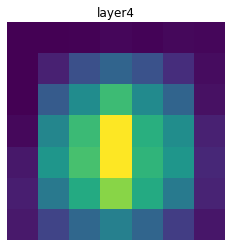

In [6]:
# The raw CAM
for name, cam in zip(cam_extractor.target_names, cams):
  plt.imshow(cam.numpy()); plt.axis('off'); plt.title(name); plt.show()

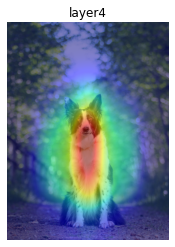

In [7]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam, mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

In [8]:
# Once you're finished, clear the hooks on your model
cam_extractor.clear_hooks()

# Advanced tricks

## Extract localization cues

In [9]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model)

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
print(softmax(out, dim=1).max())

tensor(0.9115, grad_fn=<MaxBackward1>)


In [10]:
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

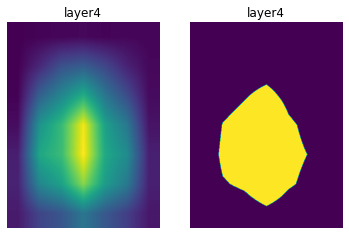

In [11]:
# Resize it
resized_cams = [resize(to_pil_image(cam), img.shape[-2:]) for cam in cams]
segmaps = [to_pil_image((resize(cam.unsqueeze(0), img.shape[-2:]).squeeze(0) >= 0.5).to(dtype=torch.float32)) for cam in cams]
# Plot it
for name, cam, seg in zip(cam_extractor.target_names, resized_cams, segmaps):
  _, axes = plt.subplots(1, 2)
  axes[0].imshow(cam); axes[0].axis('off'); axes[0].set_title(name)
  axes[1].imshow(seg); axes[1].axis('off'); axes[1].set_title(name)
  plt.show()

In [12]:
# Once you're finished, clear the hooks on your model
cam_extractor.clear_hooks()

## Fuse CAMs from multiple layers

In [13]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model, ["layer2", "layer3", "layer4"])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [14]:
# This time, there are several CAMs
for cam in cams:
  print(cam.shape)

torch.Size([28, 28])
torch.Size([14, 14])
torch.Size([7, 7])


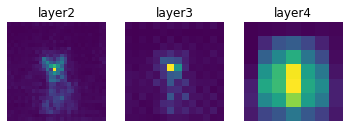

In [15]:
# The raw CAM
_, axes = plt.subplots(1, len(cam_extractor.target_names))
for idx, name, cam in zip(range(len(cam_extractor.target_names)), cam_extractor.target_names, cams):
  axes[idx].imshow(cam.numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
plt.show()

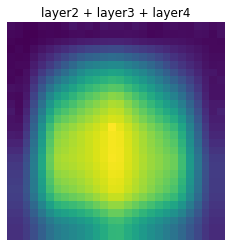

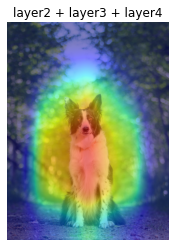

In [16]:
# Let's fuse them
fused_cam = cam_extractor.fuse_cams(cams)
# Plot the raw version
plt.imshow(fused_cam.numpy()); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()
# Plot the overlayed version
result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()

In [17]:
# Once you're finished, clear the hooks on your model
cam_extractor.clear_hooks()